# Learning Rate Schedule
We have to consider a number of aspects when it comes to the adjustment of learning rate:
- Selection of learning rate matters. If it is too large, optimization diverges. If it is too small, it takes too long to train, or we end up with a suboptimal result
-  The Rate of decay is important as well. If the learning rate remains large, we may simply end up bouncing around the minimum and thus not reach optimality
- Initialization matters. This pertains both how the parameters are set initially and also how they evolve initially
- A number of optimization variants that perform cyclical learning rate adjustment.

We will review the effects that different schedules have on accuracy and also show how this can be managed efficiently via a *learning rate scheduler* in this section
## Toy Problem
We begin with a toy problem that is cheap enough to compute easily, yet sufficiently non-trivial to illustrate some of the key aspects. For that we pick a slightly modernized version of LeNet, which uses relu instead of sigmoid, MaxPooling instead of AveragePooling, and applied to Fashion-Mnist.

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from d2l import torch as d2l
from torch.optim import lr_scheduler

def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50  == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                scheduler.step()  # using pytorch in-built scheduler
            else:
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

train loss 0.174, train acc 0.934, test acc 0.890


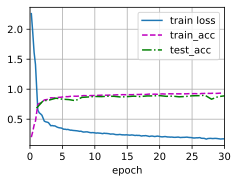

In [3]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## Scheduler
One way of adjusting the learning rate is to set it explicitly at each step. This is conveniently achieved by the set_learning_rate method. We could adjust it downward after every epoch (or even after every minibatch) in a dynamic manner in response to how optimization is progressing

In [10]:
lr = 0.1
trainer.param_groups[0]['lr'] = lr
print(f'learning rate is now: {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now: 0.10


More generally, we define a scheduler. When invoked with the number of updates it returns the appropriate value of the learning rate. We define a simple one that sets the learning rate to $\eta = \eta_0(t + 1)^{-\frac{1}{2}}$

In [14]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

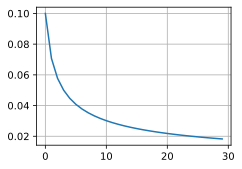

In [15]:
scheduler = SquareRootScheduler(0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.265, train acc 0.902, test acc 0.886


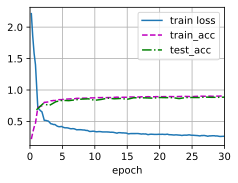

In [16]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

Two things stand out: the curve was rather more smooth tah previously. Secondly, there was less overfitting.
## Policies
While we cannot possibly cover the entire variety of learning rate schedulers, we attempt to give a brief overview of popular policies below. Common choices are polynomial decay and piecewise constant schedules. Beyond that, cosine learning schedules have been found to work well empirically on some problems. Lastly, on some problems it is beneficial to warm up the optimizer prior to using large learning rates.
### Factor Scheduler
one alternative to a polynomial decay would be a multiplicative one, that is $\eta_{t+1}\leftarrow\eta_t\cdot\alpha$ for $\alpha \in (0, 1)$. To prevent the learning rate from decaying beyond a reasonable lower bound the update equation is often modified to $\eta_{t+1}\leftarrow max(\eta_{min}, \eta_t\cdot\alpha)$

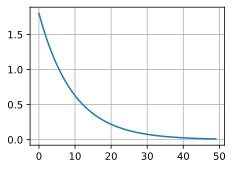

In [17]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### Multi Factor Scheduler
A common strategy for training deep networks is to keep the learning rate piecewise constant and to decrease it by a given amount every so often. That is, given a set of times when to decrease the rate, such as $s = {5, 10, 20}$ decrease $\eta_{t+1}\leftarrow\eta_t\cdot\alpha$ whenever $t \in s$. Assuming that the values are halved at each step we can implement this as follows

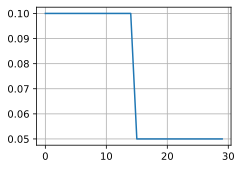

In [18]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)  # gamma is the \alpha in the formula

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler) for t in range(num_epochs)])

train loss 0.319, train acc 0.882, test acc 0.861


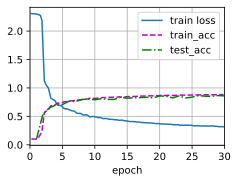

In [19]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### Cosine Scheduler
Cosine scheduler relies on the observation that we might not want to decrease the learning rate too drastically in the beginning and moreover, that we might want to "refine" the solution in the end using a very small learning rate. This results in a cosine-like schedule with the following functional form for learning rates in the range $t\in [0, T]$
$$
\eta_t=\eta_T+\frac{\eta_0-\eta_T}{2}(1 + cos(\frac{\pi t}{T}))
$$
Here $\eta_0$ is the initial learning rate, $\eta_T$ is the target rate at time T. Furthermore, for $t > T$ we simply pin the value to $\eta_T$ without increasing it again.

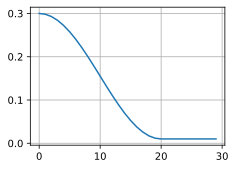

In [4]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0, warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.183, train acc 0.933, test acc 0.903


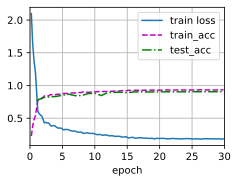

In [5]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### Warmup
In some cases initializing the parameters is not sufficient to guarantee a good solution. This is particularly a problem for some advanced network designs that may lead to unstable optimization problems. We could address this by choosing a sufficiently small rate to prevent divergence in the beginning. Unfortunately this means that progress is slow. Conversely, a large learning rate initially leads to divergence.
A rather simple fix for this dilemma is to use a warmup period during which the learning rate increases to its initial maximum and to cool down the rate until the end of the optimization process. For simplicity one typically uses a linear increase for this purpose. This leads to a schedule of the form indicated below.

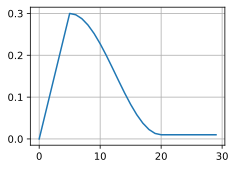

In [6]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.203, train acc 0.925, test acc 0.895


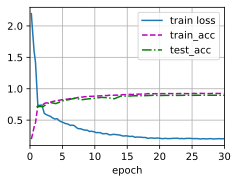

In [7]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

Warmup can be applied to any scheduler.